# BNPP X ECM

## FONCTIONS

### VAE CODE

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras import backend as K
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import wasserstein_distance
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, InputLayer, Lambda
from matplotlib.backends.backend_pdf import PdfPages
import scipy.stats as stats


class vae:
  '''
  Pour créer un object de type VAE il faut donner 2 data frames
  1 pour les rendements et 1 pour les prix
  '''

  def __init__(self, df_rendements, df_prix):
    self.df_rendements = df_rendements # dataframe des rendements 13 colonnes
    self.df_prix = df_prix # Dataframe des prix
    self.processed_data = None # C'est un tuple il va stocker le dataframe reshaped et d'autres infos, nombres de lignes...
    self.predictions = None # Dataframe des prédictions
    self.model_vae = None # Stocker le modèle vae une fois entrainé
    self.decoder_encoder = None # Stocker le décodeur et l'encodeur
    self.vae_scenarios = None  # Stocker les scenarios générés, c'est un numpy array de 3 dimensions

  def process_data(self, nb_days_predict : int, nb_jours_sequence : int):
    '''
    Fonction pour traiter les dataframes. Il faut lui donner le nombre de jours que l'on veut prédire
    Pour les retirer du dataframe. Il faut aussi lui donner le nombre de jours à séquencer, c'est à dire combien de lignes le modèle va prendre en compte pour faire une prédiction.
    '''
    df_rendements = self.df_rendements
    df_prix = self.df_prix

    # Traiter les données pour ensuite les donners au réseau de neurones
    # Au lieu d'entrainer le modèle ligne par ligne, on va faire des packets pour donner au modèles plusieurs lignes en même temps.
    # Cela permettra de capturer les dépendances temporelles entre les lignes
    donnees_brutes_0 = df_rendements.values.astype('float32')
    donnees_brutes = df_rendements[:-nb_days_predict].values.astype('float32') # On enlève les 5 derniers prix car on veut faire une simulation sur 5 jours

    prix_initiaux = df_prix.head(1)
    prix_x_jour = df_prix.iloc[-nb_days_predict]
    premier_jour = prix_initiaux.index.values[0]

    nb_jours, nb_actifs = donnees_brutes.shape  # Extraction du nombre de jours et d'actifs
    nb_donnees = nb_jours * nb_actifs  # Calcul du nombre total de données
    nb_jours_a_sequencer = nb_jours_sequence  # Définition du nombre de jours pour la séquence
    longueur_sequence = nb_jours_a_sequencer * nb_actifs  # Calcul de la longueur d'une séquence
    nb_sequence = nb_donnees//longueur_sequence
    reste_a_retirer = nb_donnees % longueur_sequence
    indice_de_retrait = reste_a_retirer // nb_actifs # Retirer les données les plus anciennes pour obtenir un découpage net.
    donnees_brutes=donnees_brutes[indice_de_retrait:]

    scaler = MinMaxScaler() # Normaliser les données pour le réseau de neurones
    donnees_normalisees = scaler.fit_transform(donnees_brutes) # plus tard, pour récupérer cette forme de données, on utilisera:
    donnees_reshaped=donnees_normalisees.reshape(nb_sequence,longueur_sequence)
    input_dim = donnees_reshaped.shape[1]
    input_dim=longueur_sequence #nombre de données dans une séquence

    self.processed_data = input_dim, donnees_reshaped, scaler, prix_initiaux, prix_x_jour, premier_jour, nb_actifs, nb_jours_a_sequencer

  def run_vae(self, activation_function : str, beta : float, nb_scenarios : int, batch_size : int):
    '''
    Fonction pour construire le vae, il faut specifier la fonction d'activation utilisé : "relu", "tanh"...
    Le beta : exemple 1.2. C'est quelle poid donner au terme de la divergence KL dans la fonction de perte
    Le nombre de scenarios que l'on veut générer :  1000
    Le batch size : exemple 32 : nombre de lignes que le modèle va traiter avant de mettre à jour ses poids.
    '''

    # Exemples de fonctions d'activation non linéaires: relu, sigmoid, tanh, softmax, softplus, softsign, elu, selu, prelu, thresholded_relu, swish

    input_dim, donnees_reshaped, scaler, prix_initiaux, prix_x_jour, premier_jour, nb_actifs, nb_jours_a_sequencer = self.processed_data

    dim_latent = input_dim//5 # Dimension de l'espace latent

    # Définition de l'encodeur
    input_layer = Input(shape=(input_dim,), name="couche_entree")
    encoder_output = Dense(input_dim//2, activation=activation_function, name="couche_encoder")(input_layer) # ajout de couches
    encoder_output = Dense(input_dim//3, activation=activation_function, name="couche_encoder1")(encoder_output)
    encoder_output = Dense(input_dim//4, activation=activation_function, name="couche_encoder2")(encoder_output)
    # Ajout de la moyenne et de la log-variance pour l'espace latent
    z_mean = Dense(dim_latent, activation=activation_function, name="z_mean")(encoder_output) # Mettre la dimension optimisé pour AE sur l'espace latent.
    z_log_var = Dense(dim_latent, activation=activation_function, name="z_log_var")(encoder_output)

    def sample(args):
      '''
      Fonction pour probabiliser l espace latent
      '''
      z_mean, z_log_var = args
      epsilon = K.random_normal(shape=K.shape(z_mean), mean=0., stddev=1.)
      return z_mean + K.exp(0.5 * z_log_var) * epsilon # modéliser la gausienne avec une loi normale

    z = Lambda(sample, name='sample')([z_mean, z_log_var]) # l'espace latent

    encoder = Model(inputs=input_layer, outputs=[z_mean, z_log_var, z], name="Encoder") # Création du modèle encodeur

    # Définition du décodeur
    decoder_input = Input(shape = (dim_latent,), name="input_decoder")
    decoder_output = Dense(input_dim//4, activation=activation_function, name="couche_decoder3")(decoder_input)
    decoder_output = Dense(input_dim//3, activation=activation_function, name="couche_decoder2")(decoder_output)
    decoder_output = Dense(input_dim//2, activation=activation_function, name="couche_decoder1")(decoder_output)
    decoder_output = Dense(input_dim , activation='linear', name="couche_sortie")(decoder_output)

    decoder = Model(inputs=decoder_input, outputs=decoder_output, name="Decoder") # Création du modèle décodeur
    self.decoder_encoder = decoder , encoder # Stocker l'encodeur et le décoder
    # Construction de l'autoencodeur en combinant encodeur et décodeur
    autoencoder_input = Input(shape=(input_dim,), name="input_autoencodeur")
    z_mean, z_log_var, z  = encoder(autoencoder_input)
    decoded = decoder(z)

    modele = Model(inputs=autoencoder_input, outputs=decoded, name="VAE") # Création du modèle autoencodeur complet

    # Définition de la fonction de perte
    def vae_loss(inputs, outputs):
        # Calcul de la perte de reconstruction
        z_mean, z_log_var, z  = encoder(inputs)
        reconstruction_loss = K.mean(K.square(inputs - outputs), axis=-1) # MSE
        divergence_kl = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis= -1) # Divergence KL
        return reconstruction_loss + beta*divergence_kl

    # Compilation du modèle avec la fonction de perte personnalisée
    modele.compile(optimizer='adam', loss=vae_loss, metrics = ["mse"])
    # Paramètre pouvant être modifié
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',     # Fonction de perte
        patience=5,             # Arreter le process si il n'y a pas d'amélioration après 5 itérations
        min_delta=0.001,        # Seuil minimum d'amélioration pour passer a l'itération suivante
        restore_best_weights=True  # Renvoyer les poids qui minimisent le plus les fonctions de perte
    )

    # Entraînement du modèle
    historique = modele.fit(donnees_reshaped, donnees_reshaped,
                            epochs = 100,
                            batch_size = batch_size,
                            callbacks = [early_stopping],
                            validation_split = 0.2,
                            shuffle = False,
                            verbose=0)
    self.model_vae = modele # Stocker le modèle
    vect_norm = np.random.normal(loc=0, scale=1, size = (nb_scenarios, dim_latent)) # Vecteur de loi normale
    sc = decoder.predict(vect_norm, verbose = 0) # Passer dans décodeur
    np_scena = sc.reshape(-1, nb_actifs) # Redimentionner pour pouvoir rescaler nos valeurs
    scena = scaler.inverse_transform(np_scena) # on retrouve nos rendements prédits
    scenarios = scena.reshape(nb_scenarios, nb_actifs, nb_jours_a_sequencer)

    # Appliquer les shocks sur le 5ieme prix le plus récent pour tous les actifs
    taux_x_last = prix_x_jour.values[np.newaxis, 3:, np.newaxis] # xieme taux en partant de la fin
    taux = taux_x_last + np.cumsum(scenarios[:,3:,:], axis = 2) # Appliquer les shocks sur x jours 1000 fois
    stock_x_last = prix_x_jour.values[np.newaxis, :3, np.newaxis] # xieme prix des actions en partant de la fin
    stock = stock_x_last*np.cumprod((1 + scenarios[:,:3,:]), axis = 2)
    vae_scena = np.concatenate([stock, taux], axis = 1)
    self.vae_scenarios = vae_scena

  def plot_predictions(self):
    '''
    Fonction pour tracer les prédictions, il faut avoir lancé le modèle avant
    '''
    input_dim, donnees_reshaped, scaler, prix_initiaux, prix_x_jour, premier_jour, nb_actifs, nb_jours_a_sequencer = self.processed_data
    modele = self.model_vae

    # Obtenir les prédictions sur les données d'entrée
    predictions = modele.predict(donnees_reshaped, verbose = 0)
    # Redimensionner les données pour revenir à leur forme d'origine
    donnees_reelles = donnees_reshaped.reshape(-1, nb_actifs)  # nb_actifs : nombre d'actifs dans notre base de données
    donnees_predites = predictions.reshape(-1, nb_actifs)
    # Ce bloc vise à remettre à l'échelle nos données puis à dénormaliser
    donnees_reelles=scaler.inverse_transform(donnees_reelles)
    donnees_predites=scaler.inverse_transform(donnees_predites)

    # rendements relatifs
    stocks = prix_initiaux[['sp500', 'Eurostock', 'EURUSD']]
    prix_predits_re = stocks.values*np.cumprod(donnees_predites[:,:3] + 1, axis=0)
    prix_reels_re = stocks.values*np.cumprod(donnees_reelles[:,:3] + 1, axis=0)
    # rendements absolut
    taux = prix_initiaux[prix_initiaux.columns[~prix_initiaux.columns.isin(['sp500', 'Eurostock', 'EURUSD'])]]
    prix_predits_abs = taux.values + np.cumsum(donnees_predites[:,3:] , axis=0)
    prix_reels_abs = taux.values + np.cumsum(donnees_reelles[:,3:] , axis=0)

    prix_reels = np.concatenate((prix_reels_re, prix_reels_abs), axis = 1)
    prix_predits = np.concatenate((prix_predits_re, prix_predits_abs), axis = 1)

    self.predictions = donnees_reelles, donnees_predites, prix_reels, prix_predits # Stocker les données de prédictions

    i = 0
    dict_names = {}
    for name in df_prix.columns:
      dict_names[name] = i
      i += 1
    col_names = df_prix.columns

    fichier_pdf = f'/content/drive/MyDrive/SharedData/vae_performance.pdf' # Enregistrer au format PDF

    with PdfPages(fichier_pdf) as pdf:
      for numero_actif in range(len(prix_initiaux.columns)):
        reel_actif = donnees_reelles[:, numero_actif]  # Colonne correspondant au numéro de l'actif pour le premier actif
        pred_actif = donnees_predites[:, numero_actif]  # Colonne correspondant au numéro de l'actif pour les prédictions
        # Créer un calendrier de jours ouvrés personnalisé
        us_business_day = CustomBusinessDay(calendar=USFederalHolidayCalendar())
        date_index = pd.date_range(start=premier_jour, periods=len(reel_actif), freq=us_business_day) # premier_jour : date de vos prix initiaux

        distance = wasserstein_distance(donnees_reelles[:,numero_actif],donnees_predites[:,numero_actif]) # Mettre la distance de Wasserstein
        if distance < 0.05 :
          message = f"Wasserstein distance {list(df_rendements.columns)[numero_actif]} : {wasserstein_distance(donnees_reelles[:,numero_actif],donnees_predites[:,numero_actif]):.2g},  Très proche"
        elif 0.05 <= distance < 0.1 :
          message = f"Wasserstein distance {list(df_rendements.columns)[numero_actif]} :  {wasserstein_distance(donnees_reelles[:,numero_actif],donnees_predites[:,numero_actif]):.2g}, Acceptable"
        else :
          message = f"Wasserstein distance {list(df_rendements.columns)[numero_actif]} : {wasserstein_distance(donnees_reelles[:,numero_actif],donnees_predites[:,numero_actif]):.2g},  Écart significatif"

        # Graphe des rendements
        fig, ax = plt.subplots(1, 2, figsize=(18, 6))
        ax[0].plot(date_index,reel_actif, label='Valeurs réelles', color='blue')
        ax[0].plot(date_index,pred_actif, label='Valeurs prédites', color='orange', linestyle='--')
        ax[0].set_title("Rendements réels vs prédits "  + str(col_names[numero_actif]), fontsize=16)
        ax[0].set_ylabel("Rendements", fontsize=14)
        ax[0].legend()
        ax[0].grid(True)
        # Graphe des prix
        ax[1].plot(date_index, prix_reels[:, numero_actif], label='Prix réels', color='blue')
        ax[1].plot(date_index, prix_predits[:, numero_actif], label='Prix prédits', color='orange', linestyle='--')
        ax[1].set_title("Prix réels vs prédits " + str(col_names[numero_actif]), fontsize=16)
        ax[1].set_ylabel("Prix", fontsize=14)
        ax[1].legend()
        ax[1].grid(True)
        fig.text(0.5, -0.05, message, ha='center', fontsize=12, fontweight='bold')
        plt.tight_layout()
        pdf.savefig()
        plt.show()
        plt.close()
        # Graphe des quantiles
        fig, ax = plt.subplots(1, 3, figsize=(18, 4))
        ax[0].set_title("QQ-Plot " + str(col_names[numero_actif]), fontsize=16)
        ax[0].set_xlabel("Quantiles théoriques", fontsize=14)
        ax[0].set_ylabel("Quantiles observés", fontsize=14)
        # Graphe réel
        reelle = stats.probplot(reel_actif, dist="norm", plot=ax[0])
        qq_points = ax[0].get_lines()[0]
        qq_points.set_marker('o')
        qq_points.set_markerfacecolor('green')
        qq_points.set_markeredgecolor('black')
        qq_points.set_markersize(6)
        ax[0].legend(["Reelle " + str(col_names[numero_actif])], loc="best")
        # Graphe des prédictions
        prediction = stats.probplot(pred_actif, dist="norm", plot=ax[1])
        qq_points.set_marker('o')
        qq_points.set_markerfacecolor('blue')
        qq_points.set_markeredgecolor('black')
        qq_points.set_markersize(6)
        ax[1].legend(["Predicted " + str(col_names[numero_actif])], loc="best")

        ax[2].hist(pred_actif, bins=50, color='navy', alpha=0.6, label = "Prediction " + str(col_names[numero_actif]), edgecolor='black') # Bleu foncé
        ax[2].hist(reel_actif, bins=50,color='tomato', alpha=0.4, label= "Réel " + str(col_names[numero_actif]), edgecolor='black') # Bleu foncé
        ax[2].legend()
        plt.tight_layout()
        pdf.savefig()
        plt.show()
        plt.close()

  def plot_latent_space(self):
    '''
    Tracer la distribution de l'espace latent, il faut avoir fait tourné les codes avant cette fonction
    '''
    decoder , encoder = self.decoder_encoder
    input_dim, donnees_reshaped, scaler, prix_initiaux, prix_x_jour, premier_jour, nb_actifs, nb_jours_a_sequencer = self.processed_data
    z_mean, z_log_var, z_latent = encoder.predict(donnees_reshaped)
    plt.hist(z_latent.flatten(), bins=50, color='navy', alpha=0.6, label='z_latent', edgecolor='black') # Bleu foncé
    plt.hist(np.random.normal(size=z_latent.flatten().shape[0]), bins=50, color='tomato', alpha=0.4, label='Normal aléatoire', edgecolor='black') # Rouge clair
    # Ajout des étiquettes, titre et légende
    plt.xlabel('Valeur')
    plt.ylabel('Fréquence')
    plt.title('Espace Latent vs N(0,1)')
    plt.legend()
    # Affichage du graphique
    plt.show()




Nous avons :
* $P(Z)$ **"Prior"** qui est une loi normale centrée réduite: $\mathcal{N}(0,1)$ c'est que on cherche à atteindre pour l'espace latent
* $P(Z|X)$ **"Posterior"** probabilité pour l'encodeur. Qui sera approximé par $Q(Z|X)$ une gaussienne car le calcul de $P(Z|X)$ n'est pas possible.
* $P(X|Z)$ **"Reconstruction"** probabilité pour le décodeur. Quelle est la probabilité de reconstruire X en partant de Z.

Nous avons fait une approximation avec le **"Posterior"** nous voulons mesurer cette approximation :
$$KL(Q(Z|X) || P(Z|X) ) = \sum_{z \in Z} Q(Z|X)log\frac{Q(Z|X)}{P(Z|X)}$$

Par calcul nous arrivons à :

$$log(P(X)) = \mathcal{L} + KL(Q(Z|X)||P(Z|X))$$

Avec $\mathcal{L}$ qui est le **variational lower bound**, et son opposé : $-\mathcal{L}$ est notre fonction de loss.

Nous voulons maximiser $log(P(X))$ qui est négatif, donc maximiser $\mathcal{L}$(négatif) soit minimiser $-\mathcal{L}$(positif). Plus précisément, minimiser :

\\
$$- \mathcal{L} = - \mathbb{E}_{Q(Z|X)}[log(P(X|Z)] + KL(Q(Z|X)||P(Z))$$

\
* $\mathbb{E}_{Q(Z|X)}[log(P(X|Z)]$ : est l'erreur sur la reconstruction, dans notre cas c'est le MSE.

\\
* $KL(Q(Z|X)||P(Z))$ : est la regularisation, le KL loss. Dans notre cas comme $P(Z)$ est une loi normale le KL loss s'écrit :
$$KL(Q(Z|X)||\mathcal{N}(0,1)) = - \frac{1}{2}\left[-\sigma_q^2 - \mu_q^2 + 1 + log(\sigma_q^2)\right]$$


Trick de reparametrisation :
Pour l'étape de la back propagation, nous devons calculer un gradient. Soit différencier une fonction.
Comment différencier Z, qui a été généré à partir de $\mathcal{N}(\mu_q,\sigma_q^2)$.

Générer Z avec $\mu_q + \sigma_q^2 \epsilon$ où $\epsilon$ suit une loi normale centré réduite. $\mathcal{N}(0,1)$ Ce cette façon cette procédure devient différenciable.

### BOOTSTRAP

In [ ]:
class Bootstrap:
  '''
  Pour créer un object de type Bootstrap il faut donner 2 data frames
  1 pour les rendements et 1 pour les prix
  '''
  def __init__(self, df_rendements, df_prix):
    self.df_rendements = df_rendements
    self.df_prix = df_prix

  def calcul_shock(self, df_ren, df_valeurs):

    stocks_actu = df_valeurs[['sp500', 'Eurostock','EURUSD']].values
    taux_actu = df_valeurs[['3M_EUR', '1Y_EUR', '5Y_EUR', '10Y_EUR', '30Y_EUR', '3M_USD', '1Y_USD',	'5Y_USD',	'10Y_USD','30Y_USD']].values

    # Calcul shock pour s&p Eurstock et Eurusd
    df_shock_stock = (1 + df_ren[['sp500', 'Eurostock', 'EURUSD']])*stocks_actu
    df_shock_stock = df_shock_stock.reset_index(drop=True)

    #Calcul shock pour les taux
    df_shock_taux = df_ren[['3M_EUR', '1Y_EUR', '5Y_EUR', '10Y_EUR', '30Y_EUR', '3M_USD', '1Y_USD',	'5Y_USD',	'10Y_USD','30Y_USD']] + taux_actu
    df_shock_taux = df_shock_taux.reset_index(drop=True)

    df_shock_1 = pd.concat([df_shock_stock, df_shock_taux], axis = 1)
    return df_shock_1

  def compute_shock(self, nb_days_predict, nb_scenarios):
    # Ici la matrice de shock prendra la forme d'un array de 3 dimension 1000*13*x (nombre de scenarios)*(nombre asset)*(nombre de jours)
    df_prix = self.df_prix
    df_rendements = self.df_rendements
    prix_x_jour = df_prix.iloc[-nb_days_predict]
    df_final_ren = df_rendements[:-nb_days_predict] # Exclure les x derniers jours
    SHOCKS = []
    days = nb_days_predict
    for d in range(1, days+1):
      df_boot = df_final_ren.sample(nb_scenarios, replace = True)
      if d == 1:
        df_shock = self.calcul_shock(df_boot, prix_x_jour) # Calcul des 1000 premiers shocks sur les prix du 5eme dernier jour
        array_shock = df_shock.to_numpy()
        SHOCKS.append(array_shock)
      else:
        df_shock = self.calcul_shock(df_boot, df_shock)
        array_shock = df_shock.to_numpy()
        SHOCKS.append(array_shock)
    array_shocks = np.stack(SHOCKS, axis = -1)
    return array_shocks


### SWAP PRICER

In [ ]:
from datetime import datetime
from numba import njit
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.backends.backend_pdf import PdfPages


class price_swap:
  '''
  Classe pour pricer un swap il faut une date de début "aaaa-mm-jj" et un tenor en année: 10
  '''

  def __init__(self, start_date, tenor):
    self.start_date = start_date
    self.tenor = tenor

  def day_count_30_360(self, end):
    start  = self.start_date
    Y1, M1, D1 = start.year, start.month, start.day
    Y2, M2, D2 = end.year, end.month, end.day
    if D1 == 31:
        D1 = 30
    if D2 == 31 and D1 == 30:
        D2 = 30
    days = (Y2 - Y1) * 360 + (M2 - M1) * 30 + (D2 - D1)
    return days/360

  def day_count_act_360(self, end):
    start_date = self.start_date
    T = (end-start_date)
    return T.days/360

  def floating_grid(self, scenarios, frequency, spread, date_conv):
    '''
    Fonction pour pricer la jambe variable
    scenarios est un numpy array de 3 dimensions
    Frequency : nombre de paiement : ex 2
    Spread en %
    Convention de date choisie : 'Act/360' ou '30/360'
    '''
    start_date = self.start_date
    dates = [
    (start_date + relativedelta(months=12 * i // frequency))
    for i in range(self.tenor * frequency + 1)]

    # Calculer le vecteur du temps avant le prochain paiement
    if date_conv == 'Act/360':
      T = np.array([self.day_count_act_360(x) for x in dates if x != start_date])
    elif date_conv == '30/360':
      T = np.array([self.day_count_30_360(x) for x in dates if x != start_date])
    else:
      print(f"{date_conv} is not valid, please specify : Act/360 or 30/360")

    arrays = []
    # Interpolation pour avoir les taux aux dates de paiments
    for j in range(scenarios.shape[2]): # Intération sur le nombres de jours à simuler
      rate_grid = np.array([
          np.interp(T, [0.25, 1, 5, 10, 30], scenarios[i, :, j])
          for i in range(scenarios.shape[0])
      ]) # Pour chaque scenario interpoler pour avoir les taux aux paiements T pour les taux au jours j
      arrays.append(rate_grid)
    rate_grid = np.stack(arrays, axis = 2) # Tout reconcaténer
    # Calcul des cash flows
    T1 = np.tile(T[1:], (len(scenarios), len(scenarios[0,0,:]), 1)).transpose(0, 2, 1) # Avoir les mêmes dimensions pour les calculs vectoriels qui vont suivre
    T2 = np.tile(T[:-1], (len(scenarios), len(scenarios[0,0,:]), 1)).transpose(0, 2, 1)
    diff_T = np.tile(1/(T[1:] - T[:-1]), (len(scenarios), len(scenarios[0,0,:]), 1)).transpose(0, 2, 1)

    rate_grid[rate_grid < 0] = 0 # Eviter les taux négatifs qui peut causer des problèmes dans la formule du FRA
    cf_grid = np.array(((((1 + rate_grid[:,1:,:])**T1) /
                        ((1 + rate_grid[:,:-1,:])**T2)))**diff_T - 1 + spread)

    # cf_grid = np.array(((((1 + rate_grid[:,1:,:])**T1)/((1 + rate_grid[:,:-1, :])**T2)))**diff_T - 1 + spread) # Formule du FRA + spread
    cf_grid = np.insert(cf_grid, 0, rate_grid[:,0,:] + spread, axis=1)

    # Calcul du discount factor
    exp = np.tile(T, (len(scenarios), 1))
    exp = np.repeat(exp[:,:, np.newaxis], scenarios.shape[2], axis = 2)
    df = np.array((1 + rate_grid/100))** - exp

    # Calcul de la PV
    pv = cf_grid * df
    price = np.sum(pv, axis = 1)

    return price

  def fixed_grid(self, scenarios, frequency, coupon, date_conv):
    '''
    Fonction pour pricer la jambe fixe
    scenarios est un numpy array de 3 dimensions
    Frequency : nombre de paiement : ex 2
    Coupon en %
    Convention de date choisie : 'Act/360' ou '30/360'
    '''
    start_date = self.start_date
    dates = [
    (start_date + relativedelta(months=12 * i // frequency))
    for i in range(self.tenor * frequency + 1)]

    if date_conv == 'Act/360':
      T = np.array([self.day_count_act_360(x) for x in dates if x != start_date])
    elif date_conv == '30/360':
      T = np.array([self.day_count_30_360(x) for x in dates if x != start_date])
    else:
      print(f"{date_conv} is not valid, please specify : Act/360 or 30/360")

    # Interpoler les taux
    arrays = []
    # Interpolation pour avoir les taux aux dates de paiments
    for j in range(scenarios.shape[2]):  # Intération sur le nombres de jours à simuler
      rate_grid = np.array([
          np.interp(T, [0.25, 1, 5, 10, 30], scenarios[i, :, j])
          for i in range(scenarios.shape[0])
      ]) # Pour chaque scenario interpoler pour avoir les taux aux paiements T pour les taux au jours j
      arrays.append(rate_grid)
    rate_grid = np.stack(arrays, axis = 2)

    # Calcul du discount factor
    exp = np.tile(T, (len(scenarios), 1))
    exp = np.repeat(exp[:,:, np.newaxis], scenarios.shape[2], axis = 2)
    df = np.array((1 + rate_grid/100))** - exp

    # Calcul de la PV
    pv = coupon  *  df
    price = np.sum(pv, axis = 1)

    return price

def swap_plot(price_simu, real_price, df_taux, title, subtitle):
  '''
  Fonction pour tracer la VAR, PFE, simulations, prix réel
  price_simu : Numpy array dim : (nb_scenarios) X (nombre de jours simulés)
  real_price : numpy array dim : 1 X nombres de jours simulés
  df_taux : dataframa avec les taux à différentes maturités et à différentes dates
  titre : str
  subtitle : str
  '''
  df_taux.index = pd.to_datetime(df_taux.index)
  plt.figure(figsize=(8, 4))
  line1, = plt.plot(df_taux.index, real_price, color = "blue", label = "Prix reel")
  simulation_min = np.min(price_simu, axis=0)
  simulation_max = np.max(price_simu, axis=0)
  plt.fill_between(df_taux.index, simulation_min, simulation_max, color="grey", alpha=0.2, label="Enveloppe simulée") # Tracer l'enveloppe des simulations

  for i in range(len(price_simu)):
    line2, = plt.plot(df_taux.index, price_simu[i,:], color = "orange", alpha = 0.05, label = "Prix simulé")
  var_pfe = np.sort(price_simu,axis=0)
  alpha = int(len(price_simu) * 0.05 - 1)
  plt.plot(df_taux.index, var_pfe[alpha, :], color = "red", linestyle='--', alpha = 1, label = "VAR a 95%") # Plot VAR
  plt.plot(df_taux.index, var_pfe[-alpha, :], color = "black", linestyle='--', alpha = 1, label = "PFE a 95%") # Plot PFE
  handles = [Line2D([0], [0], c='blue'), Line2D([0], [0], c='orange'), Line2D([0], [0], c='r', linestyle='--'), Line2D([0], [0], c='black', linestyle='--')]
  plt.legend(handles = handles, labels = ["Prix reel", "Prix simulé", 'VAR à 95%', 'PFE à 95%'])
  # Print des données statistiques
  date = df_taux.index[-1].strftime('%Y-%m-%d')
  stats_text = (f"Statistics on the {date}:\n" +
                f"  Mean: {np.mean(price_simu[:,-1]):.4f}\n" +
                f"  Std: {np.std(price_simu[:,-1]):.4f}\n" +
                f"  Min: {np.min(price_simu[:,-1]):.4f}\n" +
                f"  Max: {np.max(price_simu[:,-1]):.4f}\n" +
                f"  Median: {np.median(price_simu[:,-1]):.4f}\n" +
                f"  Q1: {np.percentile(price_simu[:,-1], 25):.4f}\n" +
                f"  Q3: {np.percentile(price_simu[:,-1], 75):.4f}\n" +
                f"  VaR: {var_pfe[49, -1]:.4f}\n" +
                f"  PFE: {var_pfe[-49, -1]:.4f}\n")
  print(stats_text)
  plt.xticks(rotation=45)
  plt.title(subtitle , fontsize=10, color="gray")
  plt.suptitle(title, fontsize=16)
  plt.xlabel("Date", fontsize=14)
  plt.ylabel("Market value", fontsize=14)
  plt.grid(True)
  fichier_pdf = f'/content/drive/MyDrive/SharedData/var_swap_bootstrap.pdf' # Enregistrer au format PDF
  plt.savefig(fichier_pdf, bbox_inches="tight")
  plt.show()

  return var_pfe[int(len(price_simu) * 0.05), :], real_price # renvoyer la VAR et prix rééls

### XML SCRAPER

In [ ]:
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd
from itertools import zip_longest

def scrape_xml(file_path):
  '''
  Fonction qui prend en entrée un chemin vers un fichier xml
  retourne un dataframe avec les informations
  '''
  tree = ET.parse(file_path)
  root = tree.getroot()
  fields = ['currency', 'fixedrateleg', 'startdate', 'maturitydate', 'frequency', 'daycount', 'couponrates',
            'referenceindex', 'spreads', 'side'] # Informations qui nous intéresse
  dict_fixed = {}
  dict_float = {}

  def print_xml(element, level=0):
      '''
      Fontion récursive qui scrappe tout le XML pour récupérer les informations
      '''
      if element.tag == 'description': # Récupérer le nom de l'instrument
        dict_fixed.setdefault('description', []).append(element.text)
        dict_float.setdefault('description', []).append(element.text)

      if element.tag == "fixedrateleg": # Récupérer les informations de la jambe fixe
        dict_fixed.setdefault('type', []).append('fixed')
        element_kid = {x.tag: x.text for x in element}
        for item in fields:
          if item not in element_kid.keys():
            dict_fixed.setdefault(item, []).append(np.nan)
          else:
            dict_fixed.setdefault(item, []).append(element_kid[item])
      elif element.tag == "floatingrateleg": # Informations sur la jambe variable
        dict_float.setdefault('type', []).append('floating')
        element_kid = {x.tag: x.text for x in element}
        for item in fields:
          if item not in element_kid.keys():
            dict_float.setdefault(item, []).append(np.nan)
          else:
            dict_float.setdefault(item, []).append(element_kid[item])

      for child in element:
          print_xml(child, level + 1)

  print_xml(root)
  dict_fixed['description'] = dict_fixed['description'][:-1]
  dict_float['description'] = dict_float['description'][:-1]
  swap_data = {key: dict_fixed[key] + dict_float[key] for key in dict_fixed.keys()}
  df_swap = pd.DataFrame(swap_data)
  df_swap['tenor'] = ((pd.to_datetime(df_swap['maturitydate']) - pd.to_datetime(df_swap['startdate'])).dt.days / 365.25).round() # Créer une colonne avec le tenor
  df_swap.set_index(df_swap.type, inplace = True)
  return df_swap

### BUILD PORTFOLIO

In [ ]:
import sys
from datetime import datetime, timedelta

class Portfolio:

  '''
  Classe pour créer un portolio, prend en entrée un dataframe avec les instruments qui constituera le portefeuille
  Ce code lance le modèle VAE ou bootstrap, price les scenarios, et plot la VAR et PFE
  '''

  def __init__(self, swap_data):
    self.swap_data = swap_data
    self.vae_model = None
    self.var = None
    self.real_price = None
    self.price_simulations = None
    self.taux_reels = None
    self.instruments = None
    self.type = None
    self.startdate = None
    self.nb_scenarios = None

  def risk_swap(self, df_rendements, df_prix, nb_days_predict, nb_scenarios, startdate, type : str):
    '''
    df_rendements : dataframe avec les rendements des actifs
    df_prix : dataframe avec les prix des actifs
    nb_days_predict : Nombre de jours ou on veut faire les prédictions : 5
    nb_scenarios : Nombre de scenarios que l'on veut générer : 1000
    Startdate : à quelle date on veut commencer à faire les simulations : "aaaa-mm-jj"
    type : type de modèle à utiliser : "VAE", ou "Bootstrap"
    '''

    # taux reels
    actif_a_conserver = [3, 4, 5, 6, 7] # Garder que les taux EUR
    df_taux_reel = df_prix.iloc[:, actif_a_conserver]
    df_taux_reel = df_taux_reel[df_taux_reel.index >= startdate]
    df_taux_reel = df_taux_reel[:nb_days_predict+1]
    if len(df_taux_reel) < nb_days_predict:
      print(f"Il y a seulement {len(df_taux_reel)} Jours ouvrés depuis le {startdate} jusqu'au {df_taux_reel.index[-1]} renseignez un nombre de jours à prédire inférieur à {len(df_taux_reel)}")
      sys.exit()
    array_tx = np.array(df_taux_reel)
    taux_reels = np.tile(array_tx, (1, 1, 1)).transpose(0,2,1) # Mettre en forme les taux réels en un array 3D pour que le swap pricer puisse le lire

    swap_data = self.swap_data
    if type == "VAE":
      model_vae = vae(df_rendements, df_prix)
      model_vae.process_data(nb_days_predict = nb_days_predict, nb_jours_sequence = nb_days_predict)
      model_vae.run_vae(activation_function = "relu", beta = 0.5, nb_scenarios = nb_scenarios, batch_size = 32) # Paramètres du VAE
      data = model_vae.vae_scenarios # Récupérer les scenarios
      self.vae_model = model_vae
    elif type == "Bootstrap":
      boot = Bootstrap(df_rendements, df_prix)
      data = boot.compute_shock(nb_days_predict, nb_scenarios)
    elif type == None:
      data = np.zeros((1,13,1))
    EUR_USD = data[:, 2, :] # Taux EUR_USD simulés
    data = data[:,actif_a_conserver,: ]

    Market_value_portfolio = []
    real_market_value_portfolio = []
    start_date = pd.to_datetime(startdate)

    for instruments in swap_data.description.unique():

      swap_df = swap_data[swap_data["description"] == instruments]
      swap_dict = swap_df.to_dict()
      tenor = int(swap_dict['tenor']['fixed'])

      if type != None:
        # Price swap simple scenarios
        swap = price_swap(start_date, tenor)
        f = swap.floating_grid(data, int(swap_dict['frequency']['floating']), float(swap_dict['spreads']['floating'])*100, swap_dict['daycount']['floating'])
        r = swap.fixed_grid(data, int(swap_dict['frequency']['fixed']), float(swap_dict['couponrates']['fixed']) * 100, swap_dict['daycount']['fixed'])
      else :
        f = 0
        r = 0

      # Price swap simple avec taux reels
      real_swap = price_swap(start_date, tenor)
      real_f = real_swap.floating_grid(taux_reels, int(swap_dict['frequency']['floating']), float(swap_dict['spreads']['floating'])*100, swap_dict['daycount']['floating'])
      real_r = real_swap.fixed_grid(taux_reels, int(swap_dict['frequency']['fixed']), float(swap_dict['couponrates']['fixed']) * 100, swap_dict['daycount']['fixed'])
      df_prix_2 = df_prix[df_prix.index >= startdate]
      EUR_USD_reel = df_prix_2.iloc[:nb_days_predict+1, 2].values

      # Si l'instrument est un cross currency, il faut prendre en compte les taux EUR_USD
      if swap_dict['currency']['fixed'] == "USD":
        ccy_fixed =  np.ones((len(data), len(data[0,0,:])))[0] # EUR_USD_reel[1:] # EUR_USD
        ccy_fixed_real =  np.ones((1, len(real_r)))[0] # EUR_USD_reel
      else :
        ccy_fixed = np.ones((len(data), len(data[0,0,:])))[0]
        ccy_fixed_real = np.ones((1, len(real_r)))[0]

      if swap_dict['currency']['floating'] == "USD":
        ccy_float = np.ones((len(data), len(data[0,0,:])))[0] # EUR_USD_reel[1:] # EUR_USD
        ccy_float_real = np.ones((1, len(real_r)))[0] # EUR_USD_reel
      else :
        ccy_float = np.ones((len(data), len(data[0,0,:])))[0]
        ccy_float_real = np.ones((1, len(real_r)))[0]

      # Ajuter les signes pour les jambes
      if swap_dict['side']['fixed'] == "Receive":
        sign_fixed = 1
        sign_float = -1
      else :
        sign_fixed = -1
        sign_float = 1

      # Market value
      real_price_swp = real_r[0] * ccy_fixed_real * sign_fixed + sign_float * real_f[0] * ccy_float_real
      price_swp = sign_fixed * r * ccy_fixed + sign_float * f * ccy_float
      nb_add_price = len(df_taux_reel.index) - nb_days_predict
      if type != None:
        price_swp = np.concatenate(
            (np.tile(real_price_swp[:nb_add_price], (price_swp.shape[0], 1)), price_swp ), axis = 1)

      Market_value_portfolio.append(price_swp)
      real_market_value_portfolio.append(real_price_swp)

    self.real_price = real_market_value_portfolio
    self.price_simulations = Market_value_portfolio
    self.taux_reels = df_taux_reel
    self.instruments = swap_data.description.unique()
    self.type = type
    self.startdate = startdate
    self.nb_scenarios = nb_scenarios

  def plot_risk(self):

    if self.type == None:
      print(f"Il n'y a pas de simulations à tracer, type = {type}, mettre 'VAE' ou 'Bootstrap'")
      sys.exit()

    real_price = self.real_price
    price_simulations = self.price_simulations

    for k in range(len(real_price)):
      # Plotter les instruments
      swap_plot(price_simulations[k], real_price[k], self.taux_reels, "Market Value " + str(self.instruments[k]), f"Contract start date : {self.startdate}, number of {self.type} simulations : {self.nb_scenarios}")
    # Plotter le portfeuille
    var, prix = swap_plot(np.sum(price_simulations, axis = 0, keepdims = True)[0], np.sum(real_price, axis = 0, keepdims = True)[0], self.taux_reels, "Market value portfolio", f"Contract start date : {self.startdate}, number of {self.type} simulations : {self.nb_scenarios}")
    self.var = var
    return

  def back_test_var(self, horizon, var, type):
    '''
    Cette fonction vise à backtester la VAR
    Nous allons faire des simulations sur une période de 100 jours par example
    Calculer la VAR sur horizon jours grâces aux scenarios générés
    Ce backtest test la VAR horizon x jours
    horizon : nombre de jours à tester : 1 par exemple
    Il compte le nombre de fois ou le rendement réel est inférieur à la variation de la VAR
    '''
    taux_reels = self.taux_reels
    taux_reels.index = pd.to_datetime(taux_reels.index)
    prix = self.real_price
    prix = np.sum(prix, axis = 0, keepdims = True)[0]
    var_change = (var/prix[0] - 1) * 100
    # Calculer les exeptions
    prix = np.diff(prix) / prix[:-1] * 100 # Calcul des rendements des prix des swaps
    nombres_exeptions = np.sum(var_change > prix[horizon:]) # Compter le nombre de fois ou la variation du prix du swap au jour j est en dessu de la variation de la VAR au jour j-1
    print("Nombre d'exceptions ", nombres_exeptions, " sur ", len(prix[:-horizon]), " observations")
    plt.plot(taux_reels.index[1:], prix, label = 'Market portfolio price')
    plt.axhline(y=var_change, linestyle='-', label=f"Var {horizon} jour", color = "red" )
    plt.title(f"Rendements journaliers réalisés avec VAR {type}")
    plt.xlabel("Date")
    plt.ylabel("Rendements en %")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()
    return


## CODE FINAL

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

rendements = '/content/drive/MyDrive/SharedData/data_assets_ren.csv'
prix = '/content/drive/MyDrive/SharedData/data_assets.csv'
xml = '/content/drive/MyDrive/SharedData/InstrumentsT_C.xml'

# Nouvelles données depuis le 10/10/2024 jusqu'en 03/2025
rendements_test = '/content/drive/MyDrive/SharedData/test_assets_ren.csv'
prix_test = '/content/drive/MyDrive/SharedData/test_assets.csv'
xml = '/content/drive/MyDrive/SharedData/InstrumentsT_C.xml'

# Data entrainement
df_prix = pd.read_csv(prix, index_col = 0)
df_rendements = pd.read_csv(rendements, index_col = 0)
# Data test
df_prix_test = pd.read_csv(prix_test, index_col = 0)
df_rendements_test = pd.read_csv(rendements_test, index_col = 0)

swap_data = scrape_xml(xml)

Mounted at /content/drive


### VAE

Statistics on the 2024-10-10:
  Mean: 18.9630
  Std: 2.8061
  Min: 12.9151
  Max: 29.4418
  Median: 18.7026
  Q1: 16.9704
  Q3: 20.8465
  VaR: 14.6648
  PFE: 24.1213



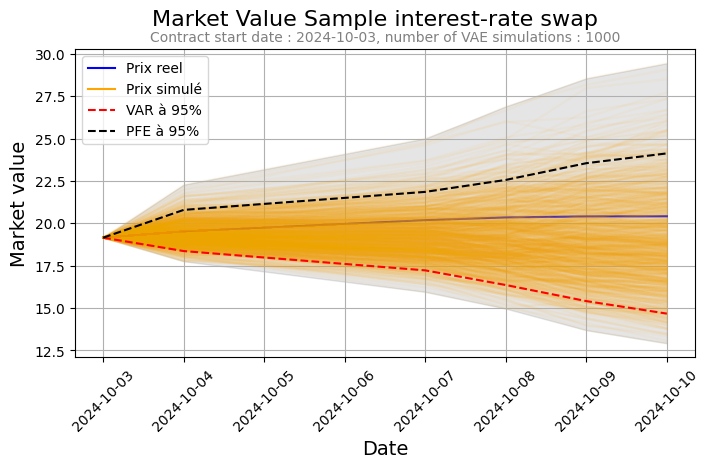

Statistics on the 2024-10-10:
  Mean: 16.2990
  Std: 3.0008
  Min: 5.1569
  Max: 22.7672
  Median: 16.5818
  Q1: 14.3006
  Q3: 18.4236
  VaR: 10.8801
  PFE: 20.8858



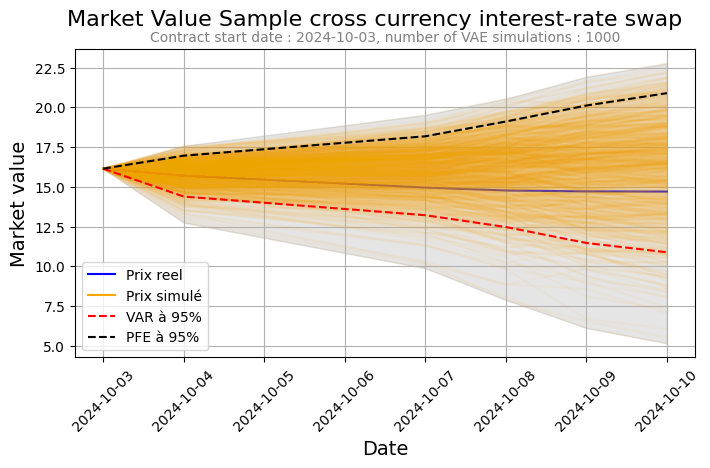

Statistics on the 2024-10-10:
  Mean: 35.2621
  Std: 0.1991
  Min: 34.5648
  Max: 35.6823
  Median: 35.2801
  Q1: 35.1255
  Q3: 35.3998
  VaR: 34.9002
  PFE: 35.5704



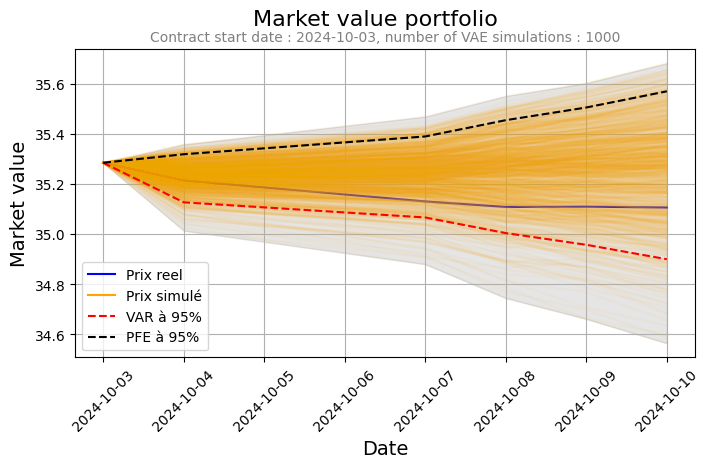

In [ ]:
nb_days_predict = 5 # Pour le backtest prendre 100 ou 150
nb_scenarios = 1000
startdate = '2024-10-03' # Pour le backtest prendre 100 ou 150

swap_portfolio = Portfolio(swap_data)
swap_portfolio.risk_swap(df_rendements, df_prix, nb_days_predict, nb_scenarios, startdate, "VAE")
swap_portfolio.plot_risk()

In [ ]:
VAR_1_jour = swap_portfolio.var[1]
print(f"VAR 1 jour : {VAR_1_jour} et prix au jour 0 : {swap_portfolio.real_price[0][0] + swap_portfolio.real_price[1][0] }")

VAR 1 jour : 35.128313120112445 et prix au jour 0 : 35.2851821451076


### Performances VAE

In [ ]:
swap_portfolio.vae_model.plot_predictions()

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


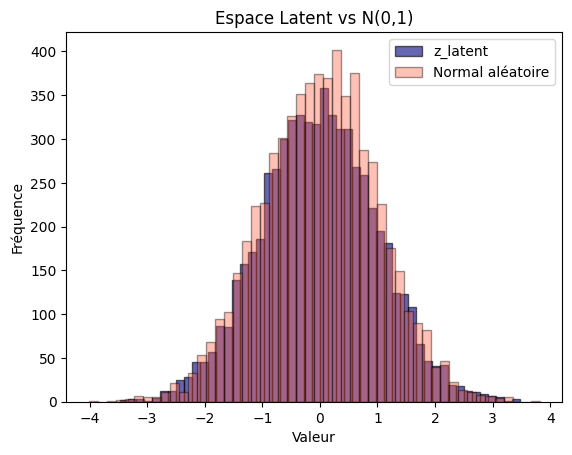

In [ ]:
swap_portfolio.vae_model.plot_latent_space()

### BACKTEST VAE

In [ ]:
nb_days_predict = 97 # Pour le backtest prendre 100 ou 150
nb_scenarios = 1000
startdate = '2024-10-03' # Pour le backtest prendre 100 ou 150

swap_portfolio = Portfolio(swap_data)
swap_portfolio.risk_swap(df_rendements_test, df_prix_test, nb_days_predict, nb_scenarios, startdate, None) # On ne génère pas de scenarios ici, on price juste notre portfeuille avec les taux réels

In [ ]:
swap_portfolio.back_test_var(1, VAR_1_jour, "VAE")

In [ ]:
4/96

### BOOTSTRAP

In [ ]:
nb_days_predict = 5 # Pour le backtest prendre 100 ou 150
nb_scenarios = 1000
startdate = '2024-10-03' # Pour le backtest prendre 100 ou 150

swap_portfolio.risk_swap(df_rendements, df_prix, nb_days_predict, nb_scenarios, startdate, "Bootstrap")
swap_portfolio.plot_risk()

In [ ]:
VAR_1_jour = swap_portfolio.var[1]
print(f"VAR 1 jour : {VAR_1_jour} et prix au jour 0 : {swap_portfolio.real_price[0][0] + swap_portfolio.real_price[1][0] }")

### BACKTEST BOOTSTRAP

In [ ]:
nb_days_predict = 97 # Pour le backtest prendre 100 ou 150
nb_scenarios = 1000
startdate = '2024-10-03' # Pour le backtest prendre 100 ou 150

swap_portfolio = Portfolio(swap_data)
swap_portfolio.risk_swap(df_rendements_test, df_prix_test, nb_days_predict, nb_scenarios, startdate, None) # On ne génère pas de scenarios ici, on price juste notre portfeuille avec les taux réels

In [ ]:
swap_portfolio.back_test_var(1, VAR_1_jour, "Bootstrap")